<a href="https://colab.research.google.com/github/skswlal/Streamlit/blob/main/web_based_RWN_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sqlite3
import pandas as pd
import random
from datetime import datetime, timedelta

# Step 1: Create the SQLite database and table
def create_database():
    conn = sqlite3.connect('precipitation_data.db')
    cursor = conn.cursor()

    cursor.execute('''
    CREATE TABLE IF NOT EXISTS precipitation_data (
        id INTEGER PRIMARY KEY,
        date TEXT,
        postal_code TEXT,
        precipitation REAL
    )
    ''')

    conn.commit()
    conn.close()

# Step 2: Generate sample data and populate the database
def populate_database():
    conn = sqlite3.connect('precipitation_data.db')
    cursor = conn.cursor()

    # Sample postal codes (you would have more in a real scenario)
    postal_codes = ['60313', '80331', '10115', '70173', '04109']

    start_date = datetime(2000, 1, 1)
    end_date = datetime(2020, 12, 31)

    current_date = start_date
    while current_date <= end_date:
        for postal_code in postal_codes:
            precipitation = round(random.uniform(0, 50), 1)  # Random precipitation between 0 and 50 mm
            cursor.execute('''
            INSERT INTO precipitation_data (date, postal_code, precipitation)
            VALUES (?, ?, ?)
            ''', (current_date.strftime('%Y-%m-%d'), postal_code, precipitation))

        current_date += timedelta(days=1)

    conn.commit()
    conn.close()

# Step 3: Function to fetch precipitation data
def fetch_precipitation_data(postal_code, start_year, end_year):
    conn = sqlite3.connect('precipitation_data.db')

    query = '''
    SELECT date, precipitation
    FROM precipitation_data
    WHERE postal_code = ?
      AND date BETWEEN ? AND ?
    ORDER BY date
    '''

    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"

    df = pd.read_sql_query(query, conn, params=(postal_code, start_date, end_date))
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    conn.close()

    return df

# Main execution
if __name__ == "__main__":
    # Create and populate the database (only need to do this once)
    create_database()
    populate_database()

    # Example usage
    postal_code = "60313"  # Frankfurt am Main
    start_year = 2000
    end_year = 2020

    precipitation_data = fetch_precipitation_data(postal_code, start_year, end_year)

    print(f"Precipitation data for postal code {postal_code} from {start_year} to {end_year}:")
    print(precipitation_data.head())

    # Calculate and print some basic statistics
    print("\nBasic statistics:")
    print(precipitation_data.describe())

    # Calculate and print annual precipitation
    annual_precipitation = precipitation_data.resample('Y').sum()
    print("\nAnnual precipitation:")
    print(annual_precipitation)


Precipitation data for postal code 60313 from 2000 to 2020:
            precipitation
date                     
2000-01-01           34.7
2000-01-02           21.5
2000-01-03           21.5
2000-01-04           35.4
2000-01-05            0.7

Basic statistics:
       precipitation
count    7671.000000
mean       24.930113
std        14.432554
min         0.000000
25%        12.400000
50%        25.000000
75%        37.400000
max        50.000000

Annual precipitation:
            precipitation
date                     
2000-12-31         8826.0
2001-12-31         9177.5
2002-12-31         8681.7
2003-12-31         8508.4
2004-12-31         9008.8
2005-12-31         8984.8
2006-12-31         9176.1
2007-12-31         8873.5
2008-12-31         8948.7
2009-12-31         9282.6
2010-12-31         8861.0
2011-12-31         9096.1
2012-12-31         9113.1
2013-12-31         9140.4
2014-12-31         9313.0
2015-12-31         9664.6
2016-12-31         9527.0
2017-12-31         9552.8
2018-12

In [ ]:
!pip install netCDF4

In [ ]:
import sqlite3
import pandas as pd
import requests
import netCDF4
import numpy as np
from datetime import datetime, timedelta
import os

# Function to download HYRAS-DE-PRE data from DWD
def download_dwd_data(year):
    base_url = "https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/precipitation/"
    filename = f"pr_hyras_1_{year}_v5-0_de.nc"
    url = base_url + filename

    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename}")
        return filename
    else:
        print(f"Failed to download {filename}")
        return None

# Function to process NetCDF file and extract precipitation data
def process_netcdf(filename, lat, lon):
    dataset = netCDF4.Dataset(filename)
    lats = dataset.variables['lat'][:]
    lons = dataset.variables['lon'][:]

    # Ensure indices are within bounds
    lat_idx = np.clip(np.argmin(np.abs(lats - lat)), 0, len(lats) - 1)
    lon_idx = np.clip(np.argmin(np.abs(lons - lon)), 0, len(lons) - 1)

    precipitation = dataset.variables['pr'][:, lat_idx, lon_idx]
    dates = netCDF4.num2date(dataset.variables['time'][:], dataset.variables['time'].units)

    # Convert cftime to datetime objects
    dates = [datetime(*d.timetuple()[:6]) for d in dates] # convert cftime objects to datetime objects

    df = pd.DataFrame({'date': dates, 'precipitation': precipitation})
    df['date'] = pd.to_datetime(df['date']) # now this should work
    df.set_index('date', inplace=True)

    dataset.close()
    os.remove(filename)  # Clean up the downloaded file

    return df

# Function to get coordinates from postal code (placeholder)
def get_coordinates_from_postal_code(postal_code):
    # This should be replaced with a real geocoding service
    # For now, we'll use fixed coordinates for demonstration
    coordinates = {
        '60313': (50.110924, 8.682127),  # Frankfurt am Main
        '80331': (48.135125, 11.581981),  # Munich
        '10115': (52.532614, 13.384773),  # Berlin
        '70173': (48.782820, 9.183075),  # Stuttgart
        '04109': (51.340199, 12.373075)   # Leipzig
    }
    return coordinates.get(postal_code, (50.110924, 8.682127))  # Default to Frankfurt if not found

# Function to fetch precipitation data for a given postal code and date range
def fetch_precipitation_data(postal_code, start_year, end_year):
    lat, lon = get_coordinates_from_postal_code(postal_code)

    all_data = []
    for year in range(start_year, end_year + 1):
        filename = download_dwd_data(year)
        if filename:
            df = process_netcdf(filename, lat, lon)
            all_data.append(df)

    if all_data:
        combined_data = pd.concat(all_data)
        return combined_data
    else:
        return pd.DataFrame()

# Main execution
if __name__ == "__main__":
    postal_code = "60313"  # Frankfurt am Main
    start_year = 2018  # Using a smaller range for demonstration
    end_year = 2020

    precipitation_data = fetch_precipitation_data(postal_code, start_year, end_year)

    if not precipitation_data.empty:
        print(f"Precipitation data for postal code {postal_code} from {start_year} to {end_year}:")
        print(precipitation_data.head())

        # Calculate and print some basic statistics
        print("\nBasic statistics:")
        print(precipitation_data['precipitation'].describe())

        # Calculate and print annual precipitation
        annual_precipitation = precipitation_data['precipitation'].resample('Y').sum()
        print("\nAnnual precipitation (mm):")
        print(annual_precipitation)

        # Calculate total precipitation for all years
        total_precipitation = precipitation_data['precipitation'].sum()
        print(f"\nTotal precipitation from {start_year} to {end_year}: {total_precipitation:.2f} mm")
    else:
        print("Failed to retrieve precipitation data.")

Downloaded pr_hyras_1_2018_v5-0_de.nc
Downloaded pr_hyras_1_2019_v5-0_de.nc
Downloaded pr_hyras_1_2020_v5-0_de.nc
Precipitation data for postal code 60313 from 2018 to 2020:
                     precipitation
date                              
2018-01-01 18:00:00            NaN
2018-01-02 18:00:00            NaN
2018-01-03 18:00:00            NaN
2018-01-04 18:00:00            NaN
2018-01-05 18:00:00            NaN

Basic statistics:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: precipitation, dtype: float64

Annual precipitation (mm):
date
2018-12-31    0.0
2019-12-31    0.0
2020-12-31    0.0
Freq: A-DEC, Name: precipitation, dtype: float32

Total precipitation from 2018 to 2020: 0.00 mm


In [ ]:
!pip install cartopy netCDF4 numpy matplotlib cartopy requests

Downloaded pr_hyras_1_2018_v5-0_de.nc


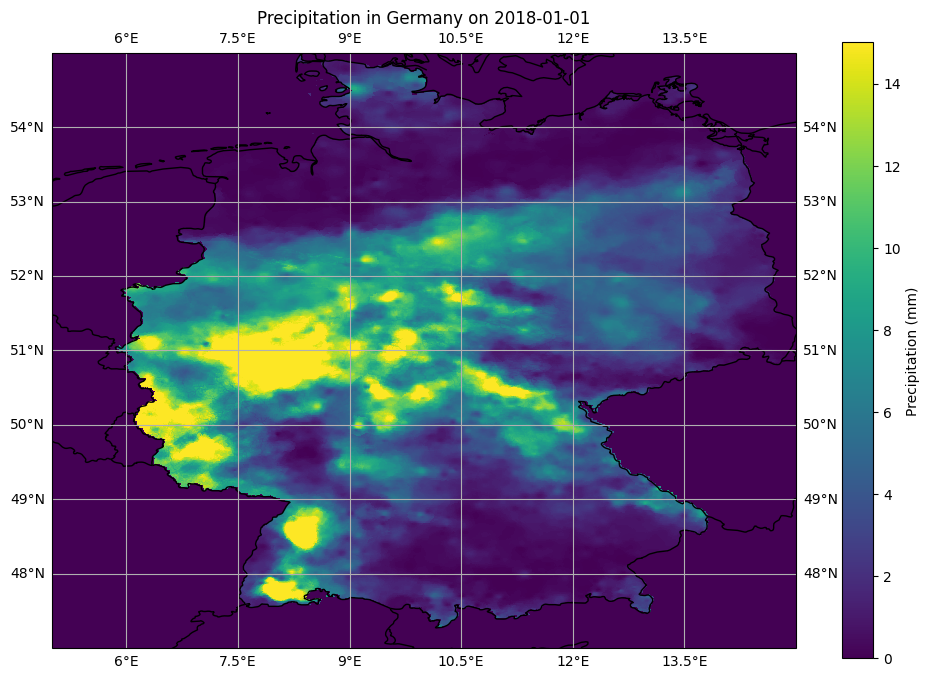

Removed file: pr_hyras_1_2018_v5-0_de.nc


In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import requests
import os
from datetime import datetime

def download_dwd_data(year):
    base_url = "https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/precipitation/"
    filename = f"pr_hyras_1_{year}_v5-0_de.nc"
    url = base_url + filename

    print(f"Downloading {filename}...")
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename}")
        return filename
    else:
        print(f"Failed to download {filename}")
        return None

def visualize_precipitation(file_path, date_index=0):
    # Open the NetCDF file
    nc = netCDF4.Dataset(file_path)

    # Read the variables
    lats = nc.variables['lat'][:]
    lons = nc.variables['lon'][:]
    precipitation = nc.variables['pr'][date_index, :, :]
    time = nc.variables['time']

    # Convert time to a readable format
    time_units = time.units
    time_calendar = time.calendar
    date = netCDF4.num2date(time[date_index], units=time_units, calendar=time_calendar)

    # Create a figure with a specific projection
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Add coastlines and borders
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)

    # Set the extent of the map to cover Germany
    ax.set_extent([5, 15, 47, 55], crs=ccrs.PlateCarree())

    # Create a color mesh of the precipitation data
    # Create a copy of precipitation data to avoid modifying the original read-only array
    precipitation_copy = np.array(precipitation)  # Create a writable copy
    mesh = ax.pcolormesh(lons, lats, precipitation_copy, transform=ccrs.PlateCarree(),
                         cmap='viridis', vmin=0, vmax=np.percentile(precipitation_copy, 99))

    # Add colorbar
    cbar = plt.colorbar(mesh, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Precipitation (mm)')

    # Set title
    plt.title(f'Precipitation in Germany on {date.strftime("%Y-%m-%d")}')

    # Add gridlines
    ax.gridlines(draw_labels=True)

    # Show the plot
    plt.show()

    # Close the NetCDF file
    nc.close()

# Main execution
if __name__ == "__main__":
    year = 2018  # You can change this to the desired year
    file_path = download_dwd_data(year)

    if file_path and os.path.exists(file_path):
        # Visualize the first day in the dataset
        visualize_precipitation(file_path, date_index=0)

        # Optionally, you can visualize other days by changing the date_index
        # For example, to visualize the 10th day:
        # visualize_precipitation(file_path, date_index=9)

        # Clean up: remove the downloaded file after visualization
        os.remove(file_path)
        print(f"Removed file: {file_path}")
    else:
        print("Failed to download or locate the data file.")

Downloaded pr_hyras_1_2018_v5-0_de.nc
Time dimension size: 365
Latitude shape: (1100, 1200)
Longitude shape: (1100, 1200)
Precipitation variable shape: (365, 1100, 1200)
Latitude range: 45.0899 to 55.7112
Longitude range: 1.8347 to 21.3904
Selected grid indices: Lat index 550, Lon index 550
Corresponding coordinates: Lat 50.6061, Lon 10.7388
Start index: 0, End index: 364
Data shape: (364, 2)


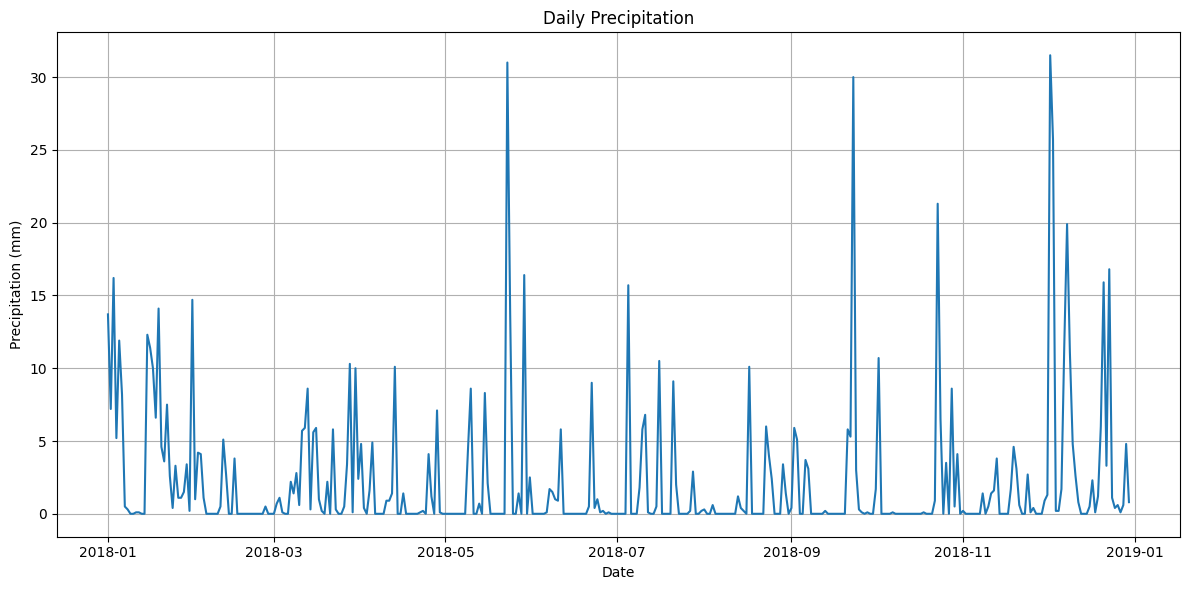


Summary Statistics:
count    364.000000
mean       2.219780
std        4.673039
min        0.000000
25%        0.000000
50%        0.100000
75%        2.200000
max       31.500000
Name: precipitation, dtype: float64

Days with precipitation: 186
Days without precipitation: 178
Removed file: pr_hyras_1_2018_v5-0_de.nc


In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import requests
import os
import cftime

def download_dwd_data(year):
    base_url = "https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/precipitation/"
    filename = f"pr_hyras_1_{year}_v5-0_de.nc"
    url = base_url + filename

    print(f"Downloading {filename}...")
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename}")
        return filename
    else:
        print(f"Failed to download {filename}")
        return None

def process_precipitation_data(file_path, start_date, end_date, lat_idx, lon_idx):
    # Open the NetCDF file
    nc = netCDF4.Dataset(file_path)

    # Read the variables
    time = nc.variables['time'][:]
    lats = nc.variables['lat'][:]
    lons = nc.variables['lon'][:]
    precipitation = nc.variables['pr']

    # Print information about the data structure
    print(f"Time dimension size: {len(time)}")
    print(f"Latitude shape: {lats.shape}")
    print(f"Longitude shape: {lons.shape}")
    print(f"Precipitation variable shape: {precipitation.shape}")

    # Convert masked arrays to regular numpy arrays
    lats = np.ma.filled(lats, np.nan)
    lons = np.ma.filled(lons, np.nan)

    print(f"Latitude range: {np.nanmin(lats):.4f} to {np.nanmax(lats):.4f}")
    print(f"Longitude range: {np.nanmin(lons):.4f} to {np.nanmax(lons):.4f}")

    print(f"Selected grid indices: Lat index {lat_idx}, Lon index {lon_idx}")

    # Handle multi-dimensional coordinate arrays
    if lats.ndim > 1:
        lat_value = lats[lat_idx, lon_idx]
        lon_value = lons[lat_idx, lon_idx]
    else:
        lat_value = lats[lat_idx]
        lon_value = lons[lon_idx]

    print(f"Corresponding coordinates: Lat {lat_value:.4f}, Lon {lon_value:.4f}")

    # Convert time to datetime objects
    time_units = nc.variables['time'].units
    time_calendar = nc.variables['time'].calendar
    dates = cftime.num2date(time, units=time_units, calendar=time_calendar)

    # Find the indices for the date range
    start_index = max(0, next((i for i, date in enumerate(dates) if date >= start_date), 0))
    end_index = min(len(dates), next((i for i, date in enumerate(dates) if date > end_date), len(dates)))

    print(f"Start index: {start_index}, End index: {end_index}")

    # Extract precipitation data for the date range and specified location
    try:
        precip_data = precipitation[start_index:end_index, lat_idx, lon_idx]
        precip_data = np.ma.filled(precip_data, np.nan)
    except IndexError as e:
        print(f"IndexError: {e}")
        print(f"Precipitation shape: {precipitation.shape}")
        print(f"Attempted indices: time[{start_index}:{end_index}], lat[{lat_idx}], lon[{lon_idx}]")
        nc.close()
        return None

    # Convert cftime objects to standard Python datetime objects
    standard_dates = [datetime(d.year, d.month, d.day) for d in dates[start_index:end_index]]

    # Create a pandas DataFrame
    df = pd.DataFrame({
        'date': standard_dates,
        'precipitation': precip_data
    })

    # Close the NetCDF file
    nc.close()

    print(f"Data shape: {df.shape}")
    return df

def visualize_precipitation(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['precipitation'])
    plt.title('Daily Precipitation')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Specify the date range you want to visualize
    START_DATE = datetime(2018, 1, 1)
    END_DATE = datetime(2018, 12, 31)

    # Define the grid indices for the location you want to retrieve precipitation data
    # These are example indices - you should adjust these based on the actual grid
    LAT_IDX = 550  # Example index for latitude
    LON_IDX = 550  # Example index for longitude

    year = START_DATE.year
    file_path = download_dwd_data(year)

    if file_path and os.path.exists(file_path):
        # Process precipitation data
        df = process_precipitation_data(file_path, START_DATE, END_DATE, LAT_IDX, LON_IDX)

        if df is not None:
            # Visualize precipitation
            visualize_precipitation(df)

            # Print some summary statistics
            print("\nSummary Statistics:")
            print(df['precipitation'].describe())

            # Print the number of days with and without precipitation
            rainy_days = (df['precipitation'] > 0).sum()
            dry_days = (df['precipitation'] == 0).sum()
            print(f"\nDays with precipitation: {rainy_days}")
            print(f"Days without precipitation: {dry_days}")
        else:
            print("Failed to process precipitation data.")

        # Clean up: remove the downloaded file after processing
        os.remove(file_path)
        print(f"Removed file: {file_path}")
    else:
        print("Failed to download or locate the data file.")

Downloaded pr_hyras_1_2018_v5-0_de.nc
Time dimension size: 365
Latitude shape: (1100, 1200)
Longitude shape: (1100, 1200)
Precipitation variable shape: (365, 1100, 1200)
Latitude range: 45.0899 to 55.7112
Longitude range: 1.8347 to 21.3904
Selected grid indices: Lat index 550, Lon index 550
Corresponding coordinates: Lat 50.6061, Lon 10.7388
Start index: 0, End index: 364
Data shape: (364, 2)


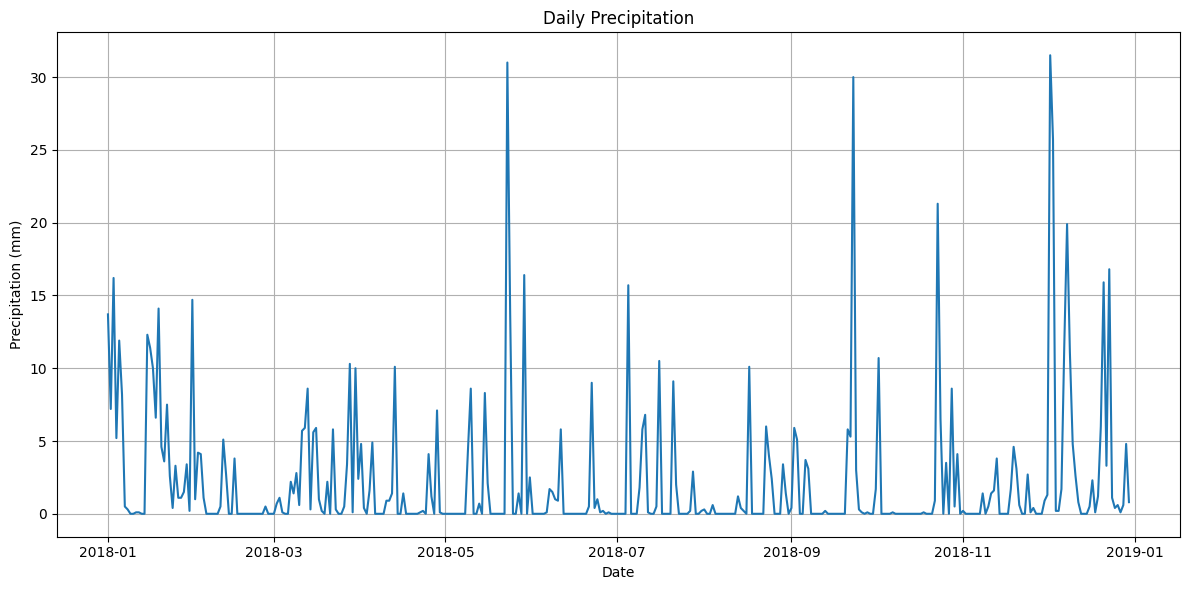


Summary Statistics:
count    364.000000
mean       2.219780
std        4.673039
min        0.000000
25%        0.000000
50%        0.100000
75%        2.200000
max       31.500000
Name: precipitation, dtype: float64

Days with precipitation: 186
Days without precipitation: 178
Removed file: pr_hyras_1_2018_v5-0_de.nc
Downloaded pr_hyras_1_2018_v5-0_de.nc
Time dimension size: 365
Latitude shape: (1100, 1200)
Longitude shape: (1100, 1200)
Precipitation variable shape: (365, 1100, 1200)
Latitude range: 45.0899 to 55.7112
Longitude range: 1.8347 to 21.3904
Selected grid indices: Lat index 550, Lon index 550
Corresponding coordinates: Lat 50.6061, Lon 10.7388
Start index: 0, End index: 364
Data shape: (364, 2)


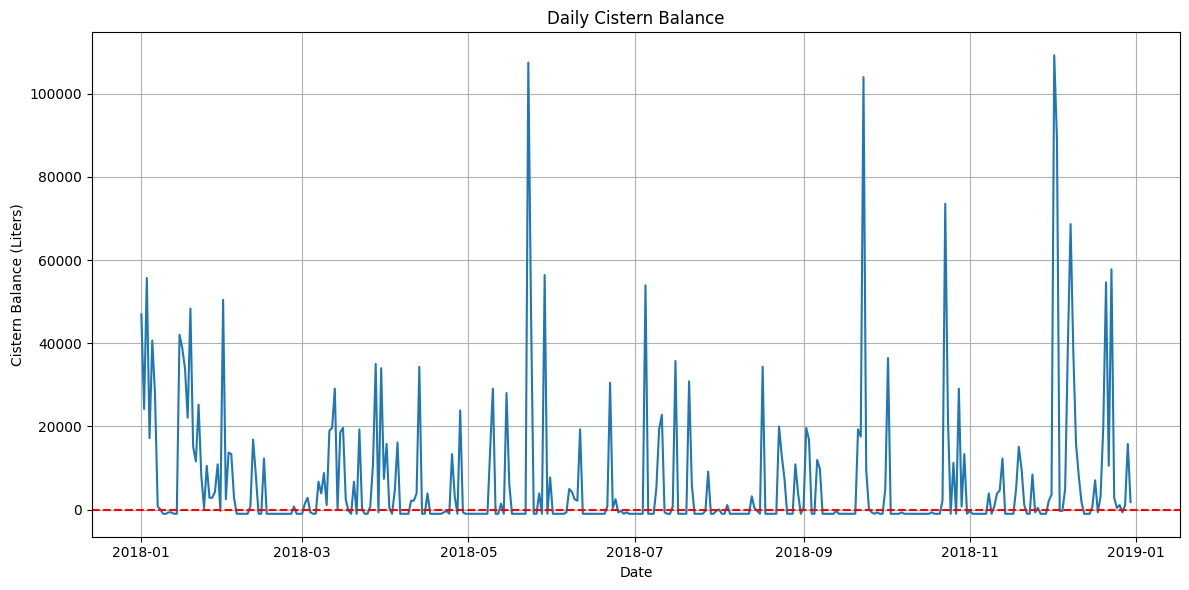


Summary Statistics for Cistern Balance:
count       364.000000
mean       6769.230780
std       16355.636577
min       -1000.000000
25%       -1000.000000
50%        -650.000000
75%        6700.000000
max      109250.000000
Name: cistern_balance, dtype: float64

Days with positive balance: 158
Days with negative balance: 206
Removed file: pr_hyras_1_2018_v5-0_de.nc


In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import requests
import os
import cftime


def download_dwd_data(year):
    base_url = "https://opendata.dwd.de/climate_environment/CDC/grids_germany/daily/hyras_de/precipitation/"
    filename = f"pr_hyras_1_{year}_v5-0_de.nc"
    url = base_url + filename

    print(f"Downloading {filename}...")
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded {filename}")
        return filename
    else:
        print(f"Failed to download {filename}")
        return None

def process_precipitation_data(file_path, start_date, end_date, lat_idx, lon_idx):
    # Open the NetCDF file
    nc = netCDF4.Dataset(file_path)

    # Read the variables
    time = nc.variables['time'][:]
    lats = nc.variables['lat'][:]
    lons = nc.variables['lon'][:]
    precipitation = nc.variables['pr']

    # Print information about the data structure
    print(f"Time dimension size: {len(time)}")
    print(f"Latitude shape: {lats.shape}")
    print(f"Longitude shape: {lons.shape}")
    print(f"Precipitation variable shape: {precipitation.shape}")

    # Convert masked arrays to regular numpy arrays
    lats = np.ma.filled(lats, np.nan)
    lons = np.ma.filled(lons, np.nan)

    print(f"Latitude range: {np.nanmin(lats):.4f} to {np.nanmax(lats):.4f}")
    print(f"Longitude range: {np.nanmin(lons):.4f} to {np.nanmax(lons):.4f}")

    print(f"Selected grid indices: Lat index {lat_idx}, Lon index {lon_idx}")

    # Handle multi-dimensional coordinate arrays
    if lats.ndim > 1:
        lat_value = lats[lat_idx, lon_idx]
        lon_value = lons[lat_idx, lon_idx]
    else:
        lat_value = lats[lat_idx]
        lon_value = lons[lon_idx]

    print(f"Corresponding coordinates: Lat {lat_value:.4f}, Lon {lon_value:.4f}")

    # Convert time to datetime objects
    time_units = nc.variables['time'].units
    time_calendar = nc.variables['time'].calendar
    dates = cftime.num2date(time, units=time_units, calendar=time_calendar)

    # Find the indices for the date range
    start_index = max(0, next((i for i, date in enumerate(dates) if date >= start_date), 0))
    end_index = min(len(dates), next((i for i, date in enumerate(dates) if date > end_date), len(dates)))

    print(f"Start index: {start_index}, End index: {end_index}")

    # Extract precipitation data for the date range and specified location
    try:
        precip_data = precipitation[start_index:end_index, lat_idx, lon_idx]
        precip_data = np.ma.filled(precip_data, np.nan)
    except IndexError as e:
        print(f"IndexError: {e}")
        print(f"Precipitation shape: {precipitation.shape}")
        print(f"Attempted indices: time[{start_index}:{end_index}], lat[{lat_idx}], lon[{lon_idx}]")
        nc.close()
        return None

    # Convert cftime objects to standard Python datetime objects
    standard_dates = [datetime(d.year, d.month, d.day) for d in dates[start_index:end_index]]

    # Create a pandas DataFrame
    df = pd.DataFrame({
        'date': standard_dates,
        'precipitation': precip_data
    })

    # Close the NetCDF file
    nc.close()

    print(f"Data shape: {df.shape}")
    return df

def visualize_precipitation(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['precipitation'])
    plt.title('Daily Precipitation')
    plt.xlabel('Date')
    plt.ylabel('Precipitation (mm)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Specify the date range you want to visualize
    START_DATE = datetime(2018, 1, 1)
    END_DATE = datetime(2018, 12, 31)

    # Define the grid indices for the location you want to retrieve precipitation data
    # These are example indices - you should adjust these based on the actual grid
    LAT_IDX = 550  # Example index for latitude
    LON_IDX = 550  # Example index for longitude

    year = START_DATE.year
    file_path = download_dwd_data(year)

    if file_path and os.path.exists(file_path):
        # Process precipitation data
        df = process_precipitation_data(file_path, START_DATE, END_DATE, LAT_IDX, LON_IDX)

        if df is not None:
            # Visualize precipitation
            visualize_precipitation(df)

            # Print some summary statistics
            print("\nSummary Statistics:")
            print(df['precipitation'].describe())

            # Print the number of days with and without precipitation
            rainy_days = (df['precipitation'] > 0).sum()
            dry_days = (df['precipitation'] == 0).sum()
            print(f"\nDays with precipitation: {rainy_days}")
            print(f"Days without precipitation: {dry_days}")
        else:
            print("Failed to process precipitation data.")

        # Clean up: remove the downloaded file after processing
        os.remove(file_path)
        print(f"Removed file: {file_path}")
    else:
        print("Failed to download or locate the data file.")


def calculate_cistern_balance(df):
    # Define roof areas
    roof_1 = 500  # m^2
    roof_2 = 1000  # m^2
    roof_3 = 2000  # m^2
    roof_area_sum_mm = roof_1 + roof_2 + roof_3

    # Calculate effective water amount for each roof
    df['effective_water_amount_roof_1_liter'] = df['precipitation'] * roof_1
    df['effective_water_amount_roof_2_liter'] = df['precipitation'] * roof_2
    df['effective_water_amount_roof_3_liter'] = df['precipitation'] * roof_3

    # Calculate total effective water amount
    df['effective_water_amount_sum_liter'] = (
        df['effective_water_amount_roof_1_liter'] +
        df['effective_water_amount_roof_2_liter'] +
        df['effective_water_amount_roof_3_liter']
    )

    # Define daily water consumption
    daily_water_consumption = {
        0: 1000,  # Monday
        1: 1000,  # Tuesday
        2: 1000,  # Wednesday
        3: 1000,  # Thursday
        4: 1000,  # Friday
        5: 1000,  # Saturday
        6: 1000   # Sunday
    }

    # Add weekday and daily water consumption
    df['weekday'] = df['date'].dt.weekday
    df['daily_water_consumption_liter'] = df['weekday'].map(daily_water_consumption)

    # Calculate cistern balance
    df['cistern_balance'] = df['effective_water_amount_sum_liter'] - df['daily_water_consumption_liter']

    return df

def visualize_cistern_balance(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['cistern_balance'])
    plt.title('Daily Cistern Balance')
    plt.xlabel('Date')
    plt.ylabel('Cistern Balance (Liters)')
    plt.axhline(y=0, color='r', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Specify the date range you want to visualize
    START_DATE = datetime(2018, 1, 1)
    END_DATE = datetime(2018, 12, 31)

    # Define the grid indices for the location you want to retrieve precipitation data
    # These are example indices - you should adjust these based on the actual grid
    LAT_IDX = 550  # Example index for latitude
    LON_IDX = 550  # Example index for longitude

    year = START_DATE.year
    file_path = download_dwd_data(year)

    if file_path and os.path.exists(file_path):
        # Process precipitation data
        df = process_precipitation_data(file_path, START_DATE, END_DATE, LAT_IDX, LON_IDX)

        if df is not None:
            # Calculate cistern balance
            df = calculate_cistern_balance(df)

            # Visualize cistern balance
            visualize_cistern_balance(df)

            # Print some summary statistics
            print("\nSummary Statistics for Cistern Balance:")
            print(df['cistern_balance'].describe())

            # Print the number of days with positive and negative balance
            positive_days = (df['cistern_balance'] > 0).sum()
            negative_days = (df['cistern_balance'] < 0).sum()
            print(f"\nDays with positive balance: {positive_days}")
            print(f"Days with negative balance: {negative_days}")
        else:
            print("Failed to process precipitation data.")

        # Clean up: remove the downloaded file after processing
        os.remove(file_path)
        print(f"Removed file: {file_path}")
    else:
        print("Failed to download or locate the data file.")

Downloaded pr_hyras_1_2018_v5-0_de.nc
Time dimension size: 365
Latitude shape: (1100, 1200)
Longitude shape: (1100, 1200)
Precipitation variable shape: (365, 1100, 1200)
Latitude range: 45.0899 to 55.7112
Longitude range: 1.8347 to 21.3904
Selected grid indices: Lat index 550, Lon index 550
Corresponding coordinates: Lat 50.6061, Lon 10.7388
Start index: 0, End index: 364
Data shape: (364, 2)


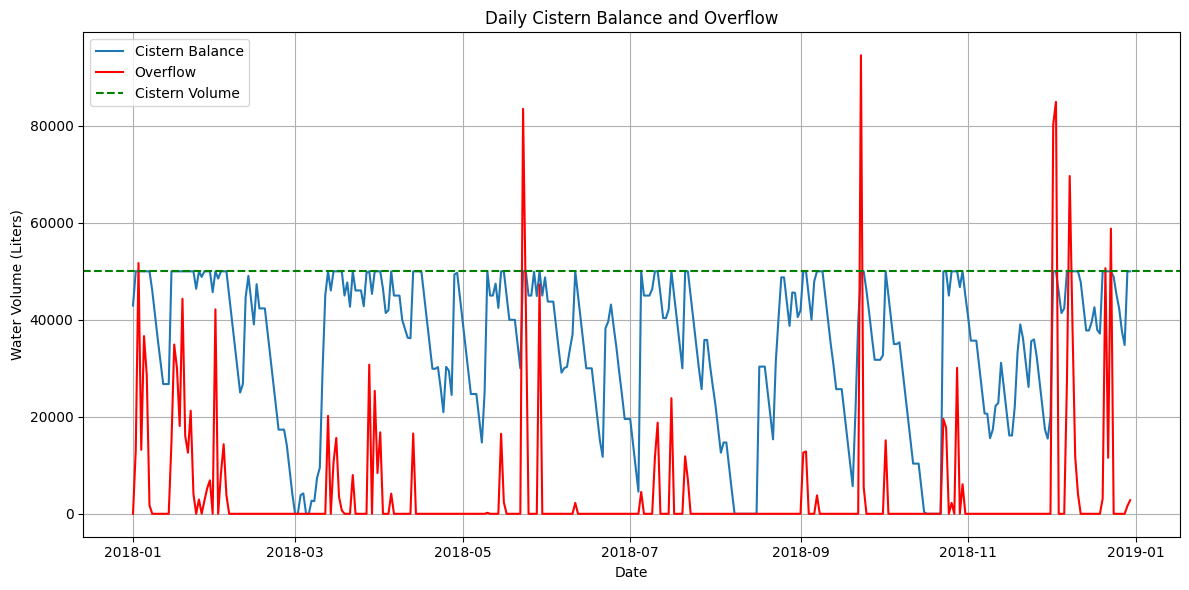


Summary Statistics for Cistern Balance:
count      364.000000
mean     34719.093407
std      14935.851796
min          0.000000
25%      25700.000000
50%      39550.000000
75%      47725.000000
max      50000.000000
Name: cistern_balance, dtype: float64

Summary Statistics for Overflow:
count      364.000000
mean      4196.153857
std      12906.352141
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      94550.000000
Name: overflow, dtype: float64

Days with overflow: 72
Removed file: pr_hyras_1_2018_v5-0_de.nc


In [ ]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta
import requests
import os
import cftime

# ... [Keep the existing download_dwd_data and process_precipitation_data functions] ...

def calculate_cistern_balance(df, cistern_volume):
    # Define roof areas
    roof_1 = 500  # m^2
    roof_2 = 1000  # m^2
    roof_3 = 2000  # m^2
    roof_area_sum_mm = roof_1 + roof_2 + roof_3

    # Calculate effective water amount for each roof
    df['effective_water_amount_roof_1_liter'] = df['precipitation'] * roof_1
    df['effective_water_amount_roof_2_liter'] = df['precipitation'] * roof_2
    df['effective_water_amount_roof_3_liter'] = df['precipitation'] * roof_3

    # Calculate total effective water amount
    df['effective_water_amount_sum_liter'] = (
        df['effective_water_amount_roof_1_liter'] +
        df['effective_water_amount_roof_2_liter'] +
        df['effective_water_amount_roof_3_liter']
    )

    # Define daily water consumption
    daily_water_consumption = {
        0: 5000,  # Monday
        1: 5000,  # Tuesday
        2: 5000,  # Wednesday
        3: 5000,  # Thursday
        4: 5000,  # Friday
        5: 0,  # Saturday
        6: 0   # Sunday
    }

    # Add weekday and daily water consumption
    df['weekday'] = df['date'].dt.weekday
    df['daily_water_consumption_liter'] = df['weekday'].map(daily_water_consumption)

    # Calculate cistern balance with limits and overflow
    df['cistern_balance'] = 0.0
    df['overflow'] = 0.0
    current_balance = 0.0

    for index, row in df.iterrows():
        new_balance = current_balance + row['effective_water_amount_sum_liter'] - row['daily_water_consumption_liter']
        if new_balance < 0:
            df.at[index, 'cistern_balance'] = 0
            current_balance = 0
        elif new_balance > cistern_volume:
            df.at[index, 'cistern_balance'] = cistern_volume
            df.at[index, 'overflow'] = new_balance - cistern_volume
            current_balance = cistern_volume
        else:
            df.at[index, 'cistern_balance'] = new_balance
            current_balance = new_balance

    return df

def visualize_cistern_balance(df, cistern_volume):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['cistern_balance'], label='Cistern Balance')
    plt.plot(df['date'], df['overflow'], label='Overflow', color='red')
    plt.title('Daily Cistern Balance and Overflow')
    plt.xlabel('Date')
    plt.ylabel('Water Volume (Liters)')
    plt.axhline(y=cistern_volume, color='g', linestyle='--', label='Cistern Volume')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Specify the date range you want to visualize
    START_DATE = datetime(2018, 1, 1)
    END_DATE = datetime(2018, 12, 31)

    # Define the grid indices for the location you want to retrieve precipitation data
    # These are example indices - you should adjust these based on the actual grid
    LAT_IDX = 550  # Example index for latitude
    LON_IDX = 550  # Example index for longitude

    # Define cistern volume
    CISTERN_VOLUME = 50000  # Liters

    year = START_DATE.year
    file_path = download_dwd_data(year)

    if file_path and os.path.exists(file_path):
        # Process precipitation data
        df = process_precipitation_data(file_path, START_DATE, END_DATE, LAT_IDX, LON_IDX)

        if df is not None:
            # Calculate cistern balance
            df = calculate_cistern_balance(df, CISTERN_VOLUME)

            # Visualize cistern balance and overflow
            visualize_cistern_balance(df, CISTERN_VOLUME)

            # Print some summary statistics
            print("\nSummary Statistics for Cistern Balance:")
            print(df['cistern_balance'].describe())

            print("\nSummary Statistics for Overflow:")
            print(df['overflow'].describe())

            # Print the number of days with overflow
            overflow_days = (df['overflow'] > 0).sum()
            print(f"\nDays with overflow: {overflow_days}")
        else:
            print("Failed to process precipitation data.")

        # Clean up: remove the downloaded file after processing
        os.remove(file_path)
        print(f"Removed file: {file_path}")
    else:
        print("Failed to download or locate the data file.")

In [ ]:
!pip install flask

In [ ]:
from flask import Flask, render_template, request, send_file
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import requests
import os
import io
import base64

app = Flask(__name__)

# ... [Include the download_dwd_data, process_precipitation_data, and calculate_cistern_balance functions here] ...

def create_plot(df, cistern_volume):
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['cistern_balance'], label='Cistern Balance')
    plt.plot(df['date'], df['overflow'], label='Overflow', color='red')
    plt.title('Daily Cistern Balance and Overflow')
    plt.xlabel('Date')
    plt.ylabel('Water Volume (Liters)')
    plt.axhline(y=cistern_volume, color='g', linestyle='--', label='Cistern Volume')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot to a bytes buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    plt.close()

    # Encode the bytes buffer in base64
    img_str = base64.b64encode(buf.getvalue()).decode()
    return img_str

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        year = int(request.form['year'])
        lat_idx = int(request.form['lat_idx'])
        lon_idx = int(request.form['lon_idx'])
        cistern_volume = float(request.form['cistern_volume'])

        start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31)

        file_path = download_dwd_data(year)

        if file_path and os.path.exists(file_path):
            df = process_precipitation_data(file_path, start_date, end_date, lat_idx, lon_idx)

            if df is not None:
                df = calculate_cistern_balance(df, cistern_volume)
                img_str = create_plot(df, cistern_volume)

                summary_stats = df['cistern_balance'].describe().to_dict()
                overflow_days = (df['overflow'] > 0).sum()

                os.remove(file_path)

                return render_template('result.html',
                                       img_str=img_str,
                                       summary_stats=summary_stats,
                                       overflow_days=overflow_days)
            else:
                return "Failed to process precipitation data."
        else:
            return "Failed to download or locate the data file."

    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=True)